Using cuda device


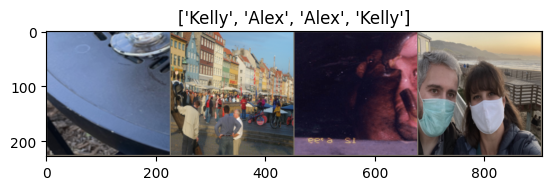

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
                for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# output train and val data to csvs
import pandas as pd
train_data = image_datasets['train'].samples
val_data = image_datasets['val'].samples
train_df = pd.DataFrame(train_data, columns=['filepath', 'label'])
val_df = pd.DataFrame(val_data, columns=['filepath', 'label'])
train_df.to_csv('train_data.csv', index=False)
val_df.to_csv('val_data.csv', index=False)

In [2]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [3]:
def visualize_model(model, num_images=40):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])
                # increase size of displayed images
                plt.gcf().set_size_inches(10, 10)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [4]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [5]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6962 Acc: 0.6388
val Loss: 0.5840 Acc: 0.7419

Epoch 1/24
----------
train Loss: 0.7280 Acc: 0.7225
val Loss: 1.0411 Acc: 0.7419

Epoch 2/24
----------
train Loss: 0.7002 Acc: 0.7225
val Loss: 0.4304 Acc: 0.8065

Epoch 3/24
----------
train Loss: 0.6214 Acc: 0.7533
val Loss: 0.9099 Acc: 0.7419

Epoch 4/24
----------
train Loss: 0.5464 Acc: 0.7797
val Loss: 0.8402 Acc: 0.7097

Epoch 5/24
----------
train Loss: 0.6095 Acc: 0.7379
val Loss: 0.6449 Acc: 0.6774

Epoch 6/24
----------
train Loss: 0.4469 Acc: 0.8370
val Loss: 1.3243 Acc: 0.6129

Epoch 7/24
----------
train Loss: 0.4050 Acc: 0.8392
val Loss: 1.0241 Acc: 0.6774

Epoch 8/24
----------
train Loss: 0.3271 Acc: 0.8700
val Loss: 0.9685 Acc: 0.6452

Epoch 9/24
----------
train Loss: 0.3156 Acc: 0.8678
val Loss: 0.6598 Acc: 0.7742

Epoch 10/24
----------
train Loss: 0.2931 Acc: 0.8767
val Loss: 0.6856 Acc: 0.7097

Epoch 11/24
----------
train Loss: 0.3439 Acc: 0.8590
val Loss: 0.5926 Acc: 0.7097

Ep

In [ ]:
# Needs fixing

# Output the final model probabilities to a CSV file
import csv
with open('model_probabilities.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['filepath', 'predicted_class', 'probability'])
    model_ft.eval()

    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_ft(inputs)
        probs = nn.Softmax(dim=1)(outputs)
        _, preds = torch.max(outputs, 1)

        for i in range(inputs.size()[0]):
            filepath = image_datasets['val'].samples[i][0]
            predicted_class = class_names[preds[i]]
            probability = probs[i][preds[i]].item()
            writer.writerow([filepath, predicted_class, probability])

<generator object <genexpr> at 0x00000160A6B28AD0>


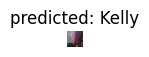

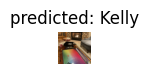

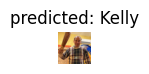

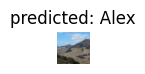

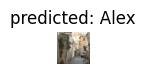

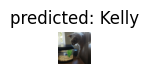

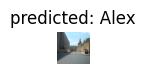

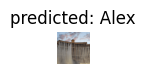

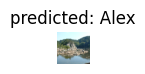

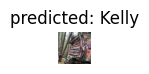

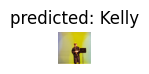

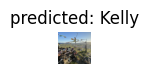

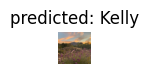

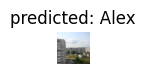

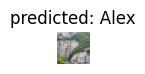

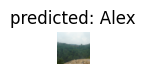

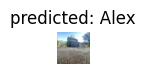

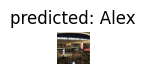

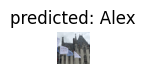

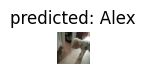

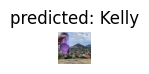

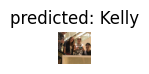

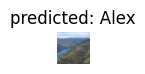

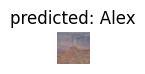

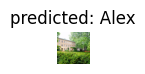

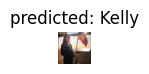

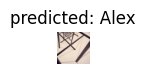

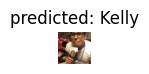

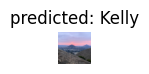

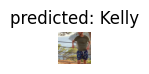

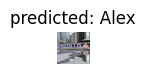

<Figure size 1000x1000 with 0 Axes>

In [16]:
visualize_model(model_ft)

In [7]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [8]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7097 Acc: 0.6189
val Loss: 0.7326 Acc: 0.6452

Epoch 1/24
----------
train Loss: 0.5937 Acc: 0.7159
val Loss: 0.6112 Acc: 0.7097

Epoch 2/24
----------
train Loss: 0.6495 Acc: 0.6960
val Loss: 0.7135 Acc: 0.6774

Epoch 3/24
----------
train Loss: 0.5867 Acc: 0.7291
val Loss: 0.6201 Acc: 0.7097

Epoch 4/24
----------
train Loss: 0.6509 Acc: 0.7070
val Loss: 0.9415 Acc: 0.7097

Epoch 5/24
----------
train Loss: 0.5805 Acc: 0.7511
val Loss: 0.7422 Acc: 0.6452

Epoch 6/24
----------
train Loss: 0.6378 Acc: 0.7511
val Loss: 0.5380 Acc: 0.6774

Epoch 7/24
----------
train Loss: 0.4999 Acc: 0.7753
val Loss: 0.4988 Acc: 0.6774

Epoch 8/24
----------
train Loss: 0.4458 Acc: 0.7952
val Loss: 0.5445 Acc: 0.7419

Epoch 9/24
----------
train Loss: 0.4912 Acc: 0.7665
val Loss: 0.6729 Acc: 0.7419

Epoch 10/24
----------
train Loss: 0.4464 Acc: 0.7907
val Loss: 0.5303 Acc: 0.7097

Epoch 11/24
----------
train Loss: 0.4554 Acc: 0.7775
val Loss: 0.5586 Acc: 0.6774

Ep

In [9]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

In [10]:
for idx in range(1,20):
    visualize_model_predictions(model_conv, f'data/val/HoldoutSet01/TestSetImage{str(idx).zfill(2)}.png')
    plt.ioff()
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'data/val/HoldoutSet01/TestSetImage01.png'